## References

In [1]:
# https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
# https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

## Prepare Notebook

In [2]:
# import packages
from sklearn.decomposition import NMF
import os
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import gensim.models
import numpy as np
from gensim.models import Word2Vec
from sklearn import decomposition
import gensim.models
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt

C:\Users\Sebastian Birk\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# display graphs in jupyter
%matplotlib inline

## Load Vectorized Corpora and Dictionaries

In [4]:
# load no pooling corpus
if (os.path.exists("tourism_no_pooling.dict")):
   dictionary_no_pooling = corpora.Dictionary.load('tourism_no_pooling.dict')
   corpus_no_pooling = corpora.MmCorpus('tourism_no_pooling.mm')
   print("Vectorized no pooling corpus loaded!")
else:
   print("Please run preprocessing script first!")

Vectorized no pooling corpus loaded!


## Load Documents and Unpreprocessed Tokenized Documents

In [5]:
# load no pooling documents
with open ('nmf_documents_no_pooling.p', 'rb') as fp:
    documents_no_pooling = pickle.load(fp)

# load no pooling unpreprocessed tokenized documents
with open ('tokenized_documents_no_pooling_unpp.p', 'rb') as fp:
    tokenized_documents_no_pooling = pickle.load(fp)

## Apply TFIDF

In [6]:
# tfidf is usually used before running NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_no_pooling = tfidf_vectorizer.fit_transform(documents_no_pooling)
tfidf_feature_names_no_pooling = tfidf_vectorizer.get_feature_names()

## Run NMF Model and Determine Number of Topics

In [7]:
# define range of possible topic numbers
kmin, kmax = 4, 8

In [8]:
# run NMF model for different number of topics
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k) 
    W = model.fit_transform(tfidf_no_pooling)
    H = model.components_    
    # store for later
    topic_models.append((k,W,H))

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...


In [9]:
# prepare tokenized documents
tokenized_documents_no_pooling = [[item.replace("#","") for item in document] for document in tokenized_documents_no_pooling]

In [10]:
# display tokenized documents
tokenized_documents_no_pooling

[['brew',
  'pub',
  'to',
  'try',
  'a',
  'few',
  'of',
  'the',
  'beers',
  'on',
  'offer',
  'olgodbarcelona',
  'ølgod',
  'triathlontraining'],
 ['art',
  'is',
  'coming',
  'face',
  'to',
  'face',
  'with',
  'yourself',
  'parc',
  'de',
  'les',
  'tres',
  'xemeneies'],
 ["today's", 'quickie', 'parc', 'de', 'les', 'tres', 'xemeneies'],
 ['all',
  'hail',
  'the',
  'freshest',
  'seafood',
  'in',
  'town',
  "let's",
  'feast',
  'hadthemostmusselsinmylife',
  'tripoftheyear'],
 ['dance',
  'to',
  'the',
  'beat',
  'of',
  'your',
  'own',
  'drum',
  'urban',
  'music',
  'live',
  'stage',
  'graffiti',
  'streetart'],
 ['i',
  'just',
  'finished',
  'walking',
  'km',
  'in',
  'h',
  'm',
  's',
  'with',
  'endomondo',
  'endorphins'],
 ['blackfriday',
  'shopping',
  'friends',
  'then',
  'bday',
  'party',
  'for',
  'mallan',
  'great',
  'food',
  'margaritas',
  'and',
  'more'],
 ['another', 'why', 'not', 'la', 'pastisseria', 'barcelona'],
 ['yesterday'

In [11]:
# build a word2vec model
w2v_model = gensim.models.Word2Vec(tokenized_documents_no_pooling, min_count=2, size=500)

In [12]:
# define function to calculate coherence
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [13]:
# define function to get top terms
def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    return top_terms

In [14]:
# run functions
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(tfidf_feature_names_no_pooling, H, topic_index, 10))
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append(calculate_coherence(w2v_model,term_rankings))
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.9681
K=05: Coherence=0.9702
K=06: Coherence=0.9756
K=07: Coherence=0.9789
K=08: Coherence=0.9792


C:\Users\Sebastian Birk\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [15]:
# graph settings
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

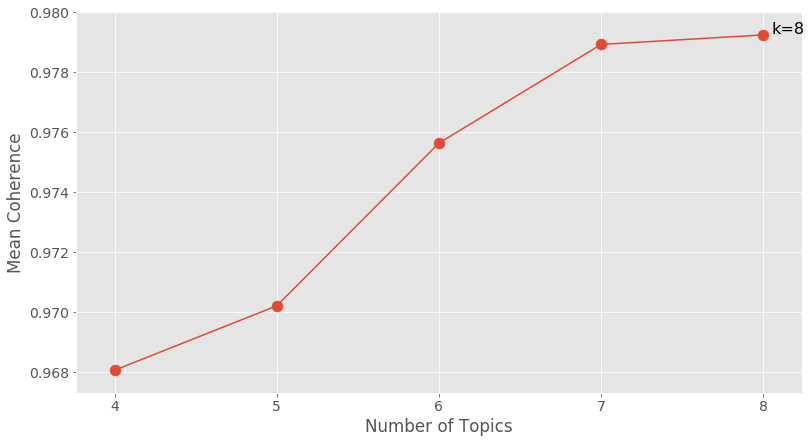

In [16]:
# create graph
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [17]:
# select the best number of topics according to tc-w2v coherence measure
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [18]:
# print the top words for each topic
for topic_index in range(k):
    descriptor = get_descriptor(tfidf_feature_names_no_pooling, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: familia, sagrada, la, basilica, inside, ll, construction, beautiful, dance, view, beauty, time, good, antoni, video, incredible, capture, night, familía, years
Topic 02: gothic, quarter, gothicquarter, art, streets, barcelona, graffiti, street, streetart, lost, travel, night, strolling, today, beautiful, love, life, bcn, favorite, time
Topic 03: just, ramblas, parc, laberint, video, arenas, aquàrium, platja, avinguda, diagonal, plaza, barceloneta, joan, guell, fundació, miró, llevant, zoo, serras, princess
Topic 04: basílica, família, sagrada, beautiful, lasagradafamilia, barcelona, la, time, inside, expiatori, place, beauty, temple, church, finished, light, gaudí, looking, look, dream
Topic 05: sagradafamilia, gaudi, architecture, travel, church, amazing, beautiful, basilica, barcelona, gaudí, catalonia, love, expiatorio, templo, building, holiday, masterpiece, inside, tourist, art
Topic 06: milà, pedreracasa, casa, pedrera, gaudi, gaudí, lapedrera, history, barcelona, beaut

#### Upon inspection, NMF works very well (seems to be more interpretable than the LDA no pooling model). However, the topics are very repetitive and not as clearly interpretable and differentiatable as the topcis detected by the LDA model with hashtag pooling. The problem of repetitions of keywords among different topics complicates the matter.